# 第二章传统目标检测

## 2.1特征工程
传统目标识别有两个非常重要的步骤：特征提取和机器学习

## 2.2 Harris 角点检测

In [ ]:
# 1 调用CV函数
import cv2
import numpy as np

In [ ]:
# 其中，
# gray为灰度图像，
# blockSize为邻域窗口的大小，
# ksize是用于Soble算子的参数，
# k是一个常量，取值为0.04~0.06
# 定义变量
blockSize = 3
ksize = 1
k = 0.04

filename = 'D:/data/Pascal Voc/VOCdevkit/VOC2007/JPEGImages/000480.jpg'
img = cv2.imread(filename)
cv2.imshow("img",img)
cv2.waitKey()
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)
dst = cv2.cornerHarris(gray,blockSize,ksize,k)
cv2.imshow("dst",dst)
cv2.waitKey()

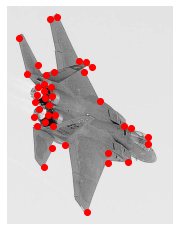

In [2]:
import cv2
from scipy.ndimage import filters
from matplotlib.pylab import *
%matplotlib inline 
# 在jupyter notebook 使用matlab 画图必加



class Harris(object):
    def __init__(self, img_path):
        self.img = cv2.imread(img_path, 0)


    def calculate_corner_strength(self):
        # 计算图像在x、y方向的梯度
        # 用滤波器采用差分求梯度的方式
        scale = self.scale
        k = self.k
        img = self.img
        gradient_imx, gradient_imy = zeros(img.shape), zeros(img.shape)
        filters.gaussian_filter(img, (scale, scale), (0, 1), gradient_imx)
        filters.gaussian_filter(img, (scale, scale), (1, 0), gradient_imy)

        # 计算矩阵M的每个分量
        I_xx = filters.gaussian_filter(gradient_imx * gradient_imx, scale)
        I_xy = filters.gaussian_filter(gradient_imx * gradient_imy, scale)
        I_yy = filters.gaussian_filter(gradient_imy * gradient_imy, scale)

        # 计算矩阵的迹、特征值和响应强度
        det_M = I_xx * I_yy - I_xy ** 2
        trace_M = I_xx + I_yy
        return det_M + k * trace_M ** 2# 这里为啥是+，与公式不符

    def corner_detect(self, img):
        # 首先对图像进行阈值处理
        _threshold = img.max() * self.threshold
        threshold_img = (img > _threshold) * 1
        coords = array(threshold_img.nonzero()).T
        candidate_values = [img[c[0], c[1]] for c in coords]
        index = argsort(candidate_values)
        # 选取领域空间，如果邻域空间距离小于min的则只选取一个角点
        # 防止角点过于密集
        neighbor = zeros(img.shape)
        neighbor[self.min:-self.min, self.min:-self.min] = 1
        filtered_coords = []
        for i in index:
            if neighbor[coords[i, 0], coords[i, 1]] == 1:
                filtered_coords.append(coords[i])
                neighbor[(coords[i, 0] - self.min):(coords[i, 0] + self.min),
                (coords[i, 1] - self.min):(coords[i, 1] + self.min)] = 0
        return filtered_coords

    def corner_plot(self, img, corner_img):
        figure()
        gray()
        imshow(img)
        plot([p[1] for p in corner_img], [p[0] for p in corner_img], 'ro')
        axis('off')
        show()

    def __call__(self, k=0.04, scale=3, min=15, threshold=0.03):
        self.k = k
        self.scale = scale
        self.min = min
        self.threshold = threshold
        strength_img = self.calculate_corner_strength()
        corner_img = self.corner_detect(strength_img)
        self.corner_plot(self.img, corner_img)


if __name__ == '__main__':
    harris = Harris("D:/data/Pascal Voc/VOCdevkit/VOC2007/JPEGImages/002619.jpg")
    harris()

## 2.3 SIFT 尺度不变特征变换
尺度空间极值检测
关键点定位
方向匹配
关键点描述

In [ ]:
import numpy as np
import cv2


def load_image(path, gray=False):
    if gray:
        img = cv2.imread(path)
        return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        return cv2.imread(path)

#生成一副对原图进行变换的图像，用于后面特征匹配，本文选择对图像进行垂直镜像变换，

def transform(origin):
    h, w, _ = origin.shape
    generate_img = np.zeros(origin.shape)
    for i in range(h):
        for j in range(w):
            generate_img[i, w - 1 - j] = origin[i, j]
    return generate_img.astype(np.uint8)


def main():
    img1 = load_image('D:/data/Pascal Voc/VOCdevkit/VOC2007/JPEGImages/002545.jpg')
    img2 = transform(img1)

    # 实例化
    sift = cv2.xfeatures2d.SIFT_create()

    # 计算关键点和描述子
    # 其中kp为关键点keypoints
    # des为描述子descriptors
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # 绘出关键点
    # 其中参数分别是源图像、关键点、输出图像、显示颜色
    img3 = cv2.drawKeypoints(img1, kp1, img1, color=(0, 255, 255))
    img4 = cv2.drawKeypoints(img2, kp2, img2, color=(0, 255, 255))

    # 参数设计和实例化
    index_params = dict(algorithm=1, trees=6)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # 利用knn计算两个描述子的匹配
    matche = flann.knnMatch(des1, des2, k=2)
    matchesMask = [[0, 0] for i in range(len(matche))]

    # 绘出匹配效果
    result = []
    for m, n in matche:
        if m.distance < 0.6 * n.distance:
            result.append([m])

    img5 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, matche, None, flags=2)
    cv2.imshow("MatchResult",img5)
    cv2.waitKey()
#     combine = np.hstack((img3, img4))
#     cv2.imshow("KeyPoints", combine)
#     cv2.waitKey()
    


if __name__ == '__main__':
    main()

## 2.4 HOG特征

In [ ]:
# 调用opencv函数
# import cv2
# hog = cv2.HOGDescriptor()
# img = cv2.imread("D:/data/Pascal Voc/VOCdevkit/VOC2007/JPEGImages/000129.jpg", cv2.IMREAD_GRAYSCALE)
# des = hog.compute(img)
# cv2.imshow("des",des)
# cv2.waitKey()

In [ ]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
# img = cv2.imread("D:/data/Pascal Voc/VOCdevkit/VOC2007/JPEGImages/000129.jpg", cv2.IMREAD_GRAYSCALE)

# 步骤一：计算梯度方向和梯度幅值 使用sobel算子，并对梯度大小加权求和
def compute_image_gradient(img):
    x_values = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
    y_values = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)
    magnitude = abs(cv2.addWeighted(x_values, 0.5, y_values, 0.5, 0))
    angle = cv2.phase(x_values, y_values, angleInDegrees=True)
    return magnitude, angle


def choose_bins(gradient_angle, unit, bin_size):
    idx = int(gradient_angle / unit)
    mod = gradient_angle % unit
    return idx, (idx + 1) % bin_size, mod

# 统计细胞单元的梯度方向
def compute_cell_gradient(cell_magnitude, cell_angle, bin_size, unit):
    centers = [0] * bin_size
    # 遍历细胞单元，统计梯度方向
    for i in range(cell_magnitude.shape[0]):
        for j in range(cell_magnitude.shape[1]):
            strength = cell_magnitude[i][j]
            gradient_angle = cell_angle[i][j]
            min_angle, max_angle, mod = choose_bins(gradient_angle, unit, bin_size)
            print(gradient_angle, unit, min_angle, max_angle)
            # 根据角度的相近程度分别对邻近的两个区间进行加权
            centers[min_angle] += (strength * (1 - (mod / unit)))
            centers[max_angle] += (strength * (mod / unit))
    return centers


def normalized(cell_gradient_vector):
    hog_vector = []
    for i in range(cell_gradient_vector.shape[0] - 1):
        for j in range(cell_gradient_vector.shape[1] - 1):
            block_vector = []
            block_vector.extend(cell_gradient_vector[i][j])
            block_vector.extend(cell_gradient_vector[i][j + 1])
            block_vector.extend(cell_gradient_vector[i + 1][j])
            block_vector.extend(cell_gradient_vector[i + 1][j + 1])
            mag = lambda vector: math.sqrt(sum(i ** 2 for i in vector))
            magnitude = mag(block_vector)
            if magnitude != 0:
                # 归一化
                normalize = lambda block_vector, magnitude: [element / magnitude for element in block_vector]
                block_vector = normalize(block_vector, magnitude)
            hog_vector.append(block_vector)
    return hog_vector


def visual(cell_gradient, height, width, cell_size, unit):
    feature_image = np.zeros([height, width])
    cell_width = cell_size / 2
    max_mag = np.array(cell_gradient).max()
    for x in range(cell_gradient.shape[0]):
        for y in range(cell_gradient.shape[1]):
            cell_grad = cell_gradient[x][y]
            cell_grad /= max_mag
            angle = 0
            angle_gap = unit
            for magnitude in cell_grad:
                angle_radian = math.radians(angle)
                x1 = int(x * cell_size + magnitude * cell_width * math.cos(angle_radian))
                y1 = int(y * cell_size + magnitude * cell_width * math.sin(angle_radian))
                x2 = int(x * cell_size - magnitude * cell_width * math.cos(angle_radian))
                y2 = int(y * cell_size - magnitude * cell_width * math.sin(angle_radian))
                cv2.line(feature_image, (y1, x1), (y2, x2), int(255 * math.sqrt(magnitude)))
                angle += angle_gap
    return feature_image


def main(img):
    cell_size = 16
    bin_size = 9
    unit = 360 // bin_size
    height, width = img.shape

    magnitude, angle = compute_image_gradient(img)

    cell_gradient_vector = np.zeros((height // cell_size, width // cell_size, bin_size))
    for i in range(cell_gradient_vector.shape[0]):
        for j in range(cell_gradient_vector.shape[1]):
            cell_magnitude = magnitude[i * cell_size:(i + 1) * cell_size,
                             j * cell_size:(j + 1) * cell_size]
            cell_angle = angle[i * cell_size:(i + 1) * cell_size,
                         j * cell_size:(j + 1) * cell_size]
            cell_gradient_vector[i][j] = compute_cell_gradient(cell_magnitude, cell_angle, bin_size, unit)
    hog_vector = normalized(cell_gradient_vector)
    hog_image = visual(cell_gradient_vector, height, width, cell_size, unit)
    plt.imshow(hog_image, cmap=plt.cm.gray)
    plt.show()


if __name__ == '__main__':
    img = cv2.imread('D:/data/Pascal Voc/VOCdevkit/VOC2007/JPEGImages/002293.jpg', cv2.IMREAD_GRAYSCALE)
    cv2.imshow("origin", img)
    cv2.waitKey()
    main(img)